<a href="https://colab.research.google.com/github/yma3/Toxicity-In-Gaming-Communities/blob/master/Jigsaw_Toxic_Communities_Challenge_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
import tensorflow as tf
import numpy as np

from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, GRU
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import pandas as pd
from tqdm import tqdm
print(tf.__version__)

2.3.0


In [2]:
# TPU Connection
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.14.138.74:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.14.138.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.14.138.74:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
# Mount google drive and select correct files

# drive.mount('/content/drive/')
data_dir = '/content/drive/My Drive/ColabData/ToxicComments/'
# !ls /content/drive/My\ Drive/ColabData/ToxicComments
os.listdir(data_dir)

['train.csv',
 'test.csv',
 'test_labels.csv',
 'leagueoflegends2020-07-30to2020-08-06.csv',
 'wow2020-07-30to2020-08-06.csv',
 'ffxiv2020-07-30to2020-08-06.csv',
 'jigsawmodel.h5']

In [4]:
traindf = pd.read_csv(data_dir+'train.csv')
testdf = pd.read_csv(data_dir+'test.csv')
test_labelsdf = pd.read_csv(data_dir+'test_labels.csv')

In [ ]:
# print(traindf.isnull().any(), testdf.isnull().any())
# traindf.head()
# testdf.head()
# test_labelsdf.head()
# test_labelsdf['toxic'].value_counts()
# traindf['toxic'].value_counts()


In [5]:
toxcols = list(traindf.columns[2:])
print(toxcols)
istoxic = [0 for i in range(len(traindf))]
ids = []
for i in tqdm(range(len(traindf))):
  for col in toxcols:
    if traindf[col][i] == 1:
      istoxic[i] = 1
traindf['istoxic'] = istoxic

  1%|          | 908/159571 [00:00<00:17, 9079.97it/s]

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


100%|██████████| 159571/159571 [00:15<00:00, 10316.87it/s]


In [6]:
toxcol_test = list(test_labelsdf.columns[1:])
print(toxcol_test)
istoxic_test = [-1 for i in range(len(test_labelsdf))]
for i in tqdm(range(len(test_labelsdf))):
  for col in toxcol_test:
    if test_labelsdf[col][i] == 0 and istoxic_test[i] != 1:
      istoxic_test[i] = 0
    if test_labelsdf[col][i] == 1:
      istoxic_test[i] = 1
testdf['istoxic'] = istoxic_test
testdf.head()

  0%|          | 531/153164 [00:00<00:28, 5304.72it/s]

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


100%|██████████| 153164/153164 [00:29<00:00, 5248.28it/s]


,id,comment_text,istoxic
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1


In [7]:
testdf['istoxic'].value_counts()

-1    89186
 0    57735
 1     6243
Name: istoxic, dtype: int64

In [8]:
testdf_clean = testdf.loc[testdf['istoxic'] != -1]
testdf_clean.head()

,id,comment_text,istoxic
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0
7,000247e83dcc1211,:Dear god this site is horrible.,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0


In [9]:
X_train, X_valid, Y_train, Y_valid = train_test_split(traindf.iloc[:,1], traindf['istoxic'], test_size = 0.2, random_state = 0)

In [10]:
MAX_FEATURES = 20000
MAXLEN = 100

tokenizer = text.Tokenizer(num_words = MAX_FEATURES)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_train = sequence.pad_sequences(X_train, maxlen = MAXLEN)
X_valid = sequence.pad_sequences(X_valid, maxlen = MAXLEN)

In [11]:
# callbacks
callback = EarlyStopping(monitor='val_loss', patience=3, verbose=0)

# Construct Model
with tpu_strategy.scope():
  model = Sequential()
  model.add(Embedding(MAX_FEATURES, 100))
  model.add(Bidirectional(LSTM(128, return_sequences=True)))
  model.add(Dropout(0.2))
  model.add(LSTM(128))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         234496    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [12]:
BATCH_SIZE = 32
EPOCHS = 5

history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs = EPOCHS, verbose = 1, validation_data=(X_valid, Y_valid))

Epoch 1/5
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


   1/3990 [..............................] - ETA: 2:11:40 - loss: 0.6932 - accuracy: 0.4375WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0040s vs `on_train_batch_end` time: 0.0257s). Check your callbacks.


3990/3990 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9532WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0020s vs `on_test_batch_end` time: 0.0149s). Check your callbacks.


3990/3990 [==============================] - 126s 32ms/step - loss: 0.1380 - accuracy: 0.9532 - val_loss: 0.1051 - val_accuracy: 0.9629
Epoch 2/5
3990/3990 [==============================] - 121s 30ms/step - loss: 0.0928 - accuracy: 0.9662 - val_loss: 0.1071 - val_accuracy: 0.9638
Epoch 3/5
3990/3990 [==============================] - 123s 31ms/step - loss: 0.0734 - accuracy: 0.9730 - val_loss: 0.1146 - val_accuracy: 0.9614
Epoch 4/5
3990/3990 [==============================] - 124s 31ms/step - loss: 0.0569 - accuracy: 0.9790 - val_loss: 0.1388 - val_accuracy: 0.9602
Epoch 5/5
3990/3990 [==============================] - 122s 31ms/step - loss: 0.0417 - accuracy: 0.9843 - val_loss: 0.1627 - val_accuracy: 0.9554


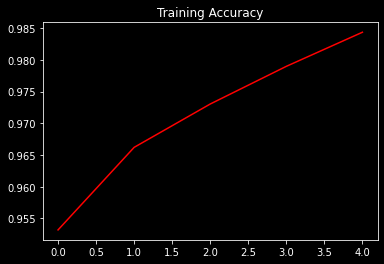

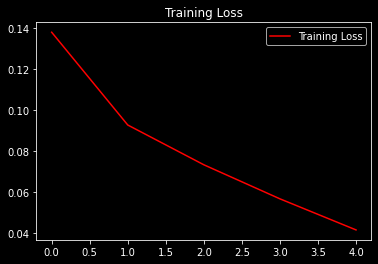

In [13]:
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])


acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.title('Training Accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training Loss')
plt.legend()

plt.show()

In [14]:
# Predictions

X_test = testdf_clean.iloc[:,1]
Y_test = testdf_clean['istoxic']
X_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(X_test, maxlen = MAXLEN)


In [15]:
# Predict and
Y_pred = model.predict_classes(X_test, verbose=1)

conf = confusion_matrix(y_true=Y_test, y_pred=Y_pred)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


   2/2000 [..............................] - ETA: 7:48WARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_predict_batch_end` time: 0.0094s). Check your callbacks.


2000/2000 [==============================] - 22s 11ms/step


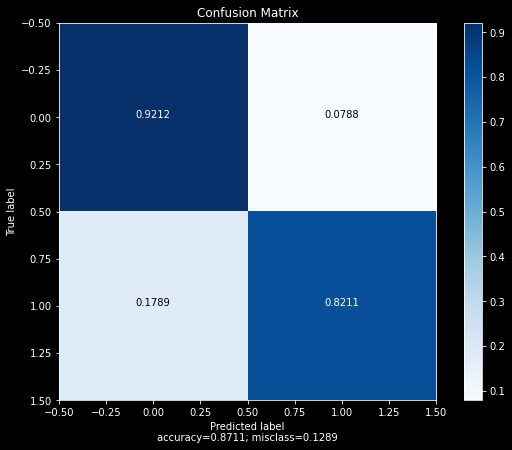

In [17]:
# Build confusion matrix

import itertools

conf_acc = np.trace(conf) / float(np.sum(conf))
conf_misclass = 1-conf_acc

plt.figure(figsize=(8, 6))
plt.imshow(conf, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
thresh = conf.max()/1.5

for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, "{:0.4f}".format(conf[i, j]),
              horizontalalignment="center",
              color="white" if conf[i, j] > thresh else "black")
    
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(conf_acc, conf_misclass))
plt.show()

In [19]:
# Save model
import json

model.save(data_dir+'jigsawmodel.h5')
token_json = tokenizer.to_json()
with open(data_dir+'token_json.txt', 'w') as outfile:
  json.dump(token_json, outfile)

In [20]:
df_ffxiv = pd.read_csv(data_dir+'ffxiv2020-07-30to2020-08-06.csv')
df_wow = pd.read_csv(data_dir+'wow2020-07-30to2020-08-06.csv')
df_lol = pd.read_csv(data_dir+'leagueoflegends2020-07-30to2020-08-06.csv')

In [21]:
df_wow['text'].fillna(' ', inplace=True) # Wow and lol dataset contain nan's, replace
df_lol['text'].fillna(' ', inplace=True)

In [23]:
X_test_ff = df_ffxiv.iloc[:,1]
X_test_wow = df_wow.iloc[:,1]
X_test_lol = df_lol.iloc[:,1]

In [25]:
X_test_ff = tokenizer.texts_to_sequences(X_test_ff)
X_test_ff = sequence.pad_sequences(X_test_ff, maxlen=MAXLEN)

X_test_wow = tokenizer.texts_to_sequences(X_test_wow)
X_test_wow = sequence.pad_sequences(X_test_wow, maxlen=MAXLEN)

X_test_lol = tokenizer.texts_to_sequences(X_test_lol)
X_test_lol = sequence.pad_sequences(X_test_lol, maxlen=MAXLEN)

In [27]:
Y_pred_ff = model.predict_classes(X_test_ff, verbose = 1)
Y_pred_wow = model.predict_classes(X_test_wow, verbose = 1)
Y_pred_lol = model.predict_classes(X_test_lol, verbose = 1)

  1/827 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0017s vs `on_predict_batch_end` time: 0.0132s). Check your callbacks.


   1/1367 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_predict_batch_end` time: 0.0076s). Check your callbacks.


   1/4038 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_predict_batch_end` time: 0.0088s). Check your callbacks.


4038/4038 [==============================] - 42s 10ms/step


In [30]:
df_ffxiv["istoxic_pred"] = Y_pred_ff
df_wow["istoxic_pred"] = Y_pred_wow
df_lol["istoxic_pred"] = Y_pred_lol

In [32]:
# df_ffxiv["istoxic_pred"].value_counts()
# df_wow["istoxic_pred"].value_counts()
# df_lol["istoxic_pred"].value_counts()

ffxiv_toxiclevels = df_ffxiv['istoxic_pred'].value_counts()[1]/len(df_ffxiv)
wow_toxiclevels = df_wow['istoxic_pred'].value_counts()[1]/len(df_wow)
lol_toxiclevels = df_lol['istoxic_pred'].value_counts()[1]/len(df_lol)

In [33]:
print("Percentage of Comments that are Toxic in Subreddits")
print("="*50)
print("FFXIV: ".ljust(10) + str(ffxiv_toxiclevels).ljust(25) + ("%.4f%%" % (ffxiv_toxiclevels*100)))
print("WoW: ".ljust(10) + str(wow_toxiclevels).ljust(25) + ("%.4f%%" % (wow_toxiclevels*100)))
print("LoL: ".ljust(10) + str(lol_toxiclevels).ljust(25) + ("%.4f%%" % (lol_toxiclevels*100)))

Percentage of Comments that are Toxic in Subreddits
FFXIV:    0.06179095446982302      6.1791%
WoW:      0.0810062893081761       8.1006%
LoL:      0.0982105540161917       9.8211%
